# PHASE 3: Spatiotemporal Analysis
## COVID-19 Disease Outbreak Tracking

This notebook covers:
- Step 12: Location Data Processing
- Step 13: Geocoding
- Step 14: Spatial Analysis
- Step 15: Temporal Analysis
- Step 16: Spatiotemporal Integration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from collections import Counter
import pickle

# Geocoding
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

# Visualization
import folium
from folium.plugins import HeatMap, MarkerCluster

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Load Processed Dataset

In [2]:
# Load dataset with predictions from Phase 2
df = pd.read_csv('covid19_tweets_with_predictions.csv')
print(f"Dataset loaded: {len(df):,} tweets")
print(f"Columns: {list(df.columns)}")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")

df.head()

Dataset loaded: 10,000 tweets
Columns: ['user_name', 'user_location', 'date', 'text', 'hashtags', 'source', 'original_text', 'cleaned_text', 'cleaned_text_length', 'word_count', 'label', 'similarity_score', 'extracted_symptoms', 'rf_prediction', 'lr_prediction']

Date range: 2020-07-25 05:40:43 to 2020-07-25 12:27:21


,user_name,user_location,date,text,hashtags,source,original_text,cleaned_text,cleaned_text_length,word_count,label,similarity_score,extracted_symptoms,rf_prediction,lr_prediction
0,ᏉᎥ☻լꂅϮ,astroworld,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,If I smelled the scent of hand sanitizers toda...,smelled scent hand sanitizers today someone pa...,72,10,1,0.868132,{'Loss of Senses': ['smell']},0,0
1,Tom Basile 🇺🇸,"New York, NY",2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey wouldnt made sense players pay respects,43,7,0,0.829704,{},0,0
2,Time4fisticuffs,"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,@diane3443 @wdunlap @realDonaldTrump Trump nev...,trump never claimed covid hoax claim effort,43,7,1,0.832598,{},0,0
3,ethel mertz,Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,@brookbanktv The one gift #COVID19 has give me...,one gift covid give appreciation simple things...,60,9,1,0.824363,{},0,0
4,DIPR-J&K,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,25 July : Media Bulletin on Novel #CoronaVirus...,july media bulletin novel coronavirusupdates c...,50,6,1,0.792585,{},0,0


## Step 12: Location Data Processing

In [3]:
# Check location data availability
location_stats = df['user_location'].notna().sum()
print(f"Tweets with location: {location_stats:,} ({location_stats/len(df)*100:.2f}%)")
print(f"Tweets without location: {len(df) - location_stats:,}")

# Filter tweets with location data
df_with_location = df[df['user_location'].notna()].copy()
print(f"\nWorking with {len(df_with_location):,} tweets that have location data")

Tweets with location: 7,954 (79.54%)
Tweets without location: 2,046

Working with 7,954 tweets that have location data


In [4]:
def clean_location(location):
    """
    Clean location strings by removing emojis and special characters
    """
    if pd.isna(location):
        return None

    location = str(location)

    # Remove emojis and special unicode characters
    location = re.sub(r'[^\x00-\x7F]+', ' ', location)

    # Remove multiple spaces
    location = re.sub(r'\s+', ' ', location).strip()

    # Remove common noise words
    noise_words = ['here', 'there', 'everywhere', 'nowhere']
    location_lower = location.lower()
    if location_lower in noise_words:
        return None

    return location if location else None

# Clean locations
df_with_location['cleaned_location'] = df_with_location['user_location'].apply(clean_location)
df_with_location = df_with_location[df_with_location['cleaned_location'].notna()]

print(f"After cleaning: {len(df_with_location):,} tweets with valid locations")

After cleaning: 7,872 tweets with valid locations



Top 20 Most Common Locations:
cleaned_location
India                         323
London, England               137
New Delhi, India              119
United Kingdom                111
London                        110
United States                 108
Mumbai, India                 103
Lagos, Nigeria                 74
UK                             68
Nigeria                        64
South Africa                   62
New Delhi                      57
Johannesburg, South Africa     56
Bhubaneshwar, India            47
Worldwide                      46
Switzerland                    44
California, USA                44
Nairobi, Kenya                 42
Mumbai                         41
Chennai, India                 41
Name: count, dtype: int64


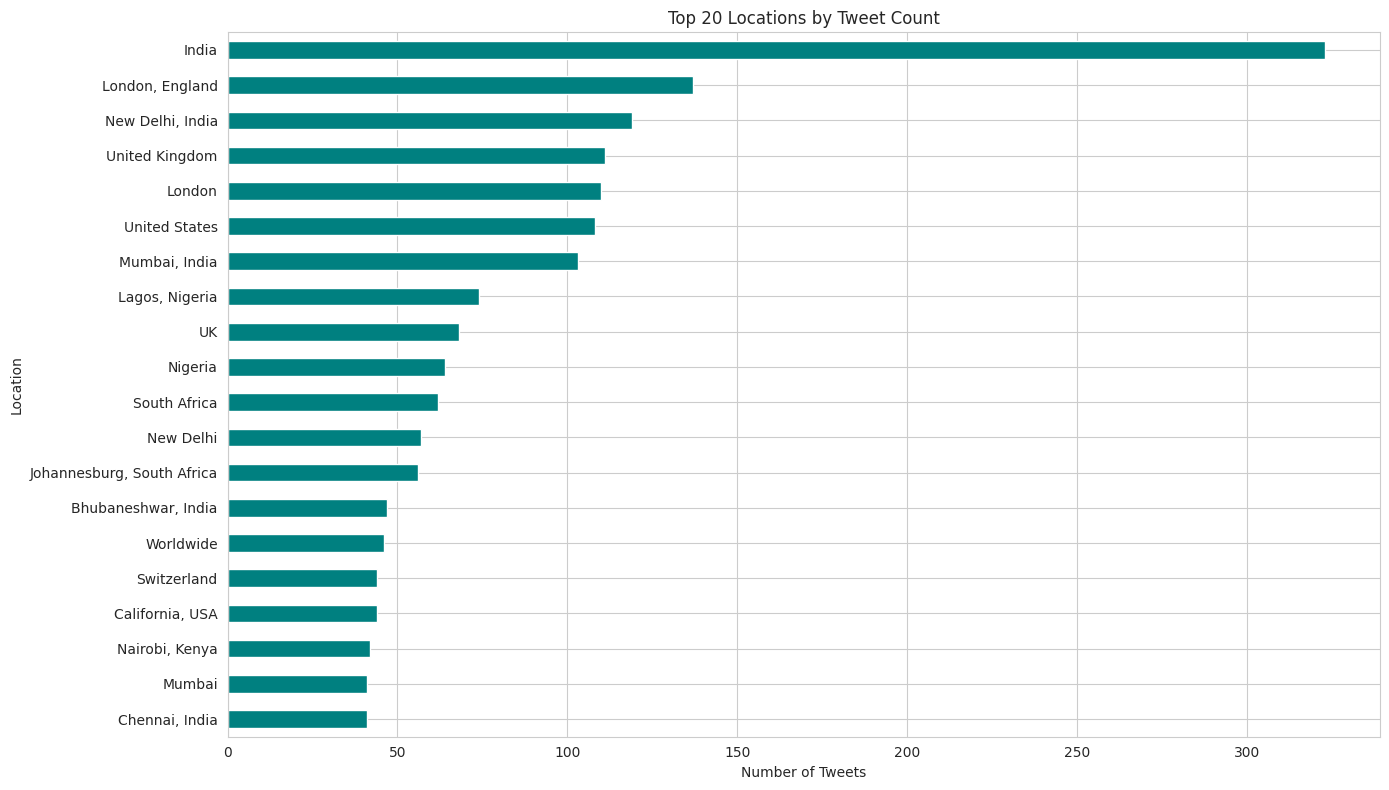

In [5]:
# Count tweets per location
location_counts = df_with_location['cleaned_location'].value_counts()

print(f"\nTop 20 Most Common Locations:")
print(location_counts.head(20))

# Visualize top locations
plt.figure(figsize=(14, 8))
location_counts.head(20).plot(kind='barh', color='teal')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.title('Top 20 Locations by Tweet Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 13: Geocoding
### Convert location strings to coordinates

In [6]:
# Initialize geocoder
geolocator = Nominatim(user_agent="covid19_analysis")

# Create cache for geocoded locations
geocode_cache = {}

def geocode_location(location, cache):
    """
    Geocode a location string to latitude and longitude
    Uses cache to avoid repeated API calls
    """
    if location in cache:
        return cache[location]

    try:
        time.sleep(1)  # Rate limiting - be respectful to the API
        location_data = geolocator.geocode(location, timeout=10)

        if location_data:
            result = {
                'latitude': location_data.latitude,
                'longitude': location_data.longitude,
                'address': location_data.address
            }
            cache[location] = result
            return result
        else:
            cache[location] = None
            return None

    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Error geocoding {location}: {e}")
        return None

print("Geocoder initialized. Ready to process locations.")

Geocoder initialized. Ready to process locations.


In [7]:
# Geocode top locations (limit to top 100 for demonstration)
# For full dataset, remove the [:100] slice
top_locations = df_with_location['cleaned_location'].value_counts().head(100).index.tolist()

print(f"Geocoding {len(top_locations)} locations...")
print("This may take several minutes due to API rate limiting.")

geocoded_results = []
for i, location in enumerate(top_locations, 1):
    result = geocode_location(location, geocode_cache)
    geocoded_results.append({
        'location': location,
        'geocoded': result is not None,
        'latitude': result['latitude'] if result else None,
        'longitude': result['longitude'] if result else None,
        'full_address': result['address'] if result else None
    })

    if i % 10 == 0:
        print(f"Processed {i}/{len(top_locations)} locations...")

geocoded_df = pd.DataFrame(geocoded_results)
print(f"\nGeocoding complete!")
print(f"Successfully geocoded: {geocoded_df['geocoded'].sum()} locations")
print(f"Failed to geocode: {(~geocoded_df['geocoded']).sum()} locations")
print(f"Success rate: {geocoded_df['geocoded'].mean()*100:.2f}%")

Geocoding 100 locations...
This may take several minutes due to API rate limiting.
Processed 10/100 locations...
Processed 20/100 locations...
Processed 30/100 locations...
Processed 40/100 locations...
Processed 50/100 locations...
Processed 60/100 locations...
Processed 70/100 locations...
Processed 80/100 locations...
Processed 90/100 locations...
Processed 100/100 locations...

Geocoding complete!
Successfully geocoded: 96 locations
Failed to geocode: 4 locations
Success rate: 96.00%


In [8]:
# Save geocoded results and cache
geocoded_df.to_csv('geocoded_locations.csv', index=False)
with open('geocode_cache.pkl', 'wb') as f:
    pickle.dump(geocode_cache, f)

print("Geocoded data saved!")
print("  - geocoded_locations.csv")
print("  - geocode_cache.pkl")

Geocoded data saved!
  - geocoded_locations.csv
  - geocode_cache.pkl


In [9]:
# Merge geocoded data back to main dataframe
df_with_location = df_with_location.merge(
    geocoded_df[['location', 'latitude', 'longitude']],
    left_on='cleaned_location',
    right_on='location',
    how='left'
)

# Filter to only geocoded tweets
df_geo = df_with_location[df_with_location['latitude'].notna()].copy()
print(f"\nDataset with coordinates: {len(df_geo):,} tweets")


Dataset with coordinates: 3,119 tweets


## Step 14: Spatial Analysis
### Identify disease hotspots and geographic distribution

In [10]:
# Filter disease-related tweets (label = 1)
df_disease = df_geo[df_geo['label'] == 1].copy()
print(f"Disease-related tweets with location: {len(df_disease):,}")

# Count disease mentions per location
disease_by_location = df_disease.groupby('cleaned_location').agg({
    'label': 'count',
    'latitude': 'first',
    'longitude': 'first'
}).rename(columns={'label': 'disease_count'}).reset_index()

disease_by_location = disease_by_location.sort_values('disease_count', ascending=False)

print(f"\nTop 20 Disease Hotspots:")
print(disease_by_location.head(20)[['cleaned_location', 'disease_count']])

Disease-related tweets with location: 2,406

Top 20 Disease Hotspots:
              cleaned_location  disease_count
41                       India            275
66            New Delhi, India             99
53             London, England             95
90               United States             94
61               Mumbai, India             90
89              United Kingdom             85
52                      London             82
12         Bhubaneshwar, India             44
51              Lagos, Nigeria             44
64                   New Delhi             44
86                          UK             43
83                 Switzerland             42
94                   Worldwide             41
80                South Africa             40
45  Johannesburg, South Africa             37
92                   WORLDWIDE             36
22              Chennai, India             35
70                     Nigeria             33
19                      Canada             32
18        

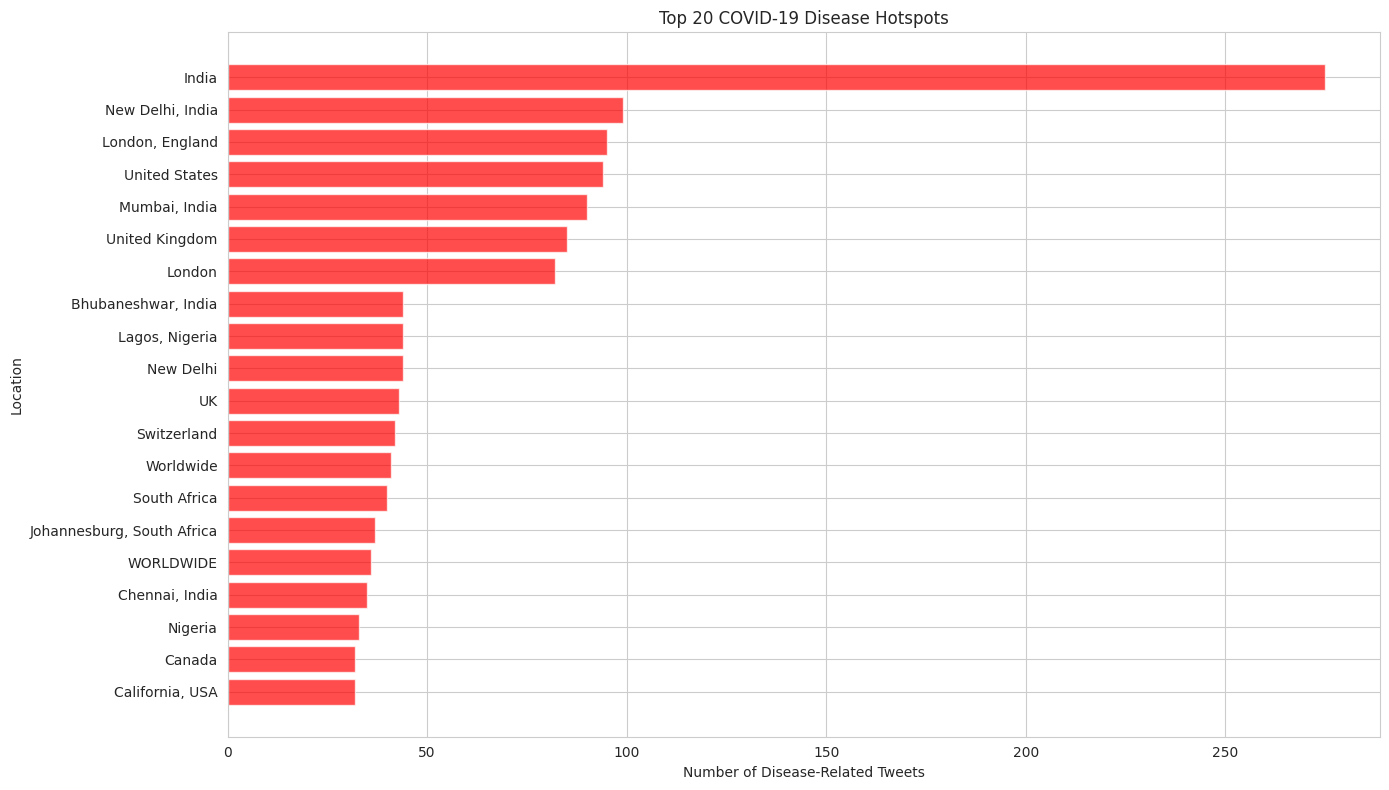

In [11]:
# Visualize hotspots
plt.figure(figsize=(14, 8))
top_hotspots = disease_by_location.head(20)
plt.barh(range(len(top_hotspots)), top_hotspots['disease_count'], color='red', alpha=0.7)
plt.yticks(range(len(top_hotspots)), top_hotspots['cleaned_location'])
plt.xlabel('Number of Disease-Related Tweets')
plt.ylabel('Location')
plt.title('Top 20 COVID-19 Disease Hotspots')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
# Calculate disease rate per location (disease tweets / total tweets)
total_by_location = df_geo.groupby('cleaned_location').size().reset_index(name='total_tweets')

location_stats = disease_by_location.merge(total_by_location, on='cleaned_location')
location_stats['disease_rate'] = (location_stats['disease_count'] / location_stats['total_tweets'] * 100).round(2)
location_stats = location_stats.sort_values('disease_rate', ascending=False)

print("\nTop 20 Locations by Disease Rate (%)")
print(location_stats[['cleaned_location', 'disease_count', 'total_tweets', 'disease_rate']].head(20))


Top 20 Locations by Disease Rate (%)
             cleaned_location  disease_count  total_tweets  disease_rate
15                  WORLDWIDE             36            36        100.00
30              #AFRICA #MENA             22            22        100.00
51                     Brazil             13            13        100.00
75            Berlin, Germany             10            10        100.00
69        Edinburgh, Scotland             11            11        100.00
55                      Earth             13            13        100.00
46                     Odisha             14            14        100.00
11                Switzerland             42            44         95.45
7         Bhubaneshwar, India             44            47         93.62
52                Pune, India             13            14         92.86
56                Chicago, IL             13            14         92.86
53                     mumbai             13            14         92.86
62  Belfast, 

### Create Interactive Map of Disease Hotspots

In [14]:
# Create base map centered on mean coordinates
mean_lat = df_geo['latitude'].mean()
mean_lon = df_geo['longitude'].mean()

disease_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=2)

# Add markers for top hotspots
top_hotspots = disease_by_location.head(50)

for idx, row in top_hotspots.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=min(row['disease_count'] / 10, 20),  # Scale radius
        popup=f"{row['cleaned_location']}<br>Disease Tweets: {row['disease_count']}",
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.6
    ).add_to(disease_map)

# Save map
disease_map.save('disease_hotspots_map.html')
print("Disease hotspots map saved to '../data/processed/disease_hotspots_map.html'")
print("Open this file in a browser to view the interactive map.")

disease_map

Disease hotspots map saved to '../data/processed/disease_hotspots_map.html'
Open this file in a browser to view the interactive map.


### Create Heatmap

In [16]:
# Create heatmap of disease tweets
heat_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=2)

# Prepare heat data
heat_data = [[row['latitude'], row['longitude']] for idx, row in df_disease.iterrows()]

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(heat_map)

# Save heatmap
heat_map.save('disease_heatmap.html')
print("Disease heatmap saved to '../data/processed/disease_heatmap.html'")

heat_map

Disease heatmap saved to '../data/processed/disease_heatmap.html'


## Step 15: Temporal Analysis
### Analyze disease mentions over time

In [19]:
# Ensure date column is datetime
df_geo['date'] = pd.to_datetime(df_geo['date'])

# Extract time components
df_geo['year'] = df_geo['date'].dt.year
df_geo['month'] = df_geo['date'].dt.month
df_geo['day'] = df_geo['date'].dt.day
df_geo['hour'] = df_geo['date'].dt.hour
df_geo['day_of_week'] = df_geo['date'].dt.day_name()
df_geo['week'] = df_geo['date'].dt.isocalendar().week



In [20]:
# Count tweets per day
daily_tweets = df_geo.groupby(df_geo['date'].dt.date).agg({
    'label': ['count', 'sum']
}).reset_index()
daily_tweets.columns = ['date', 'total_tweets', 'disease_tweets']
daily_tweets['date'] = pd.to_datetime(daily_tweets['date'])
daily_tweets['disease_rate'] = (daily_tweets['disease_tweets'] / daily_tweets['total_tweets'] * 100).round(2)

print(f"\nDaily statistics:")
print(daily_tweets.head(10))


Daily statistics:
        date  total_tweets  disease_tweets  disease_rate
0 2020-07-25          3119            2406         77.14


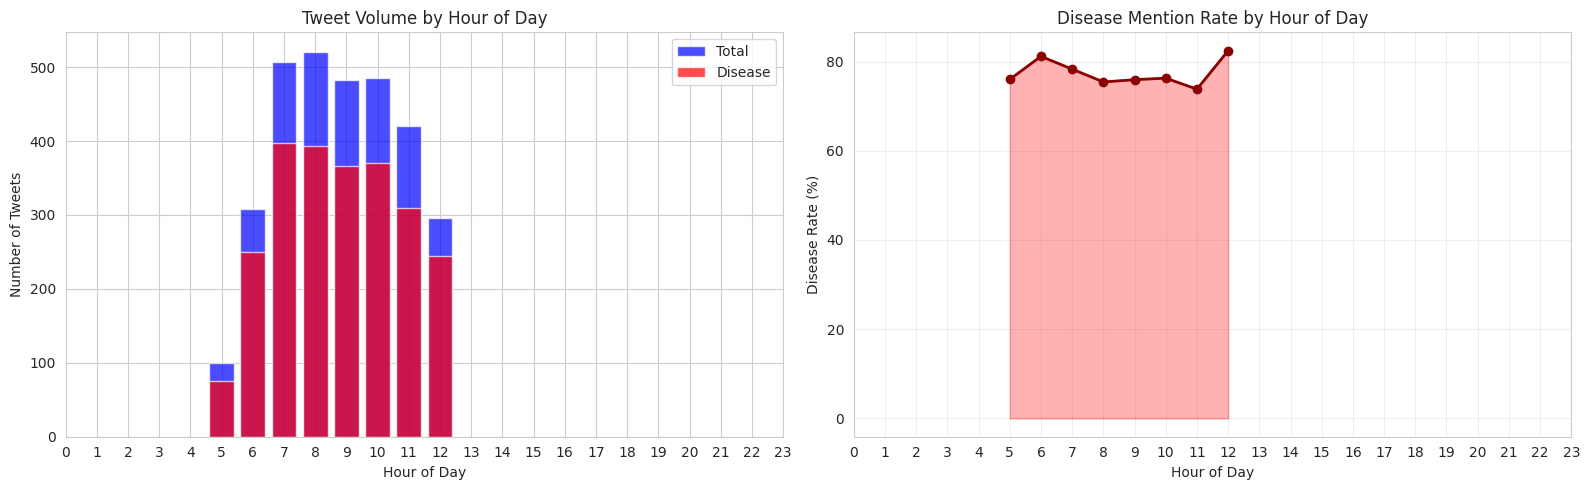

In [22]:
# Hourly analysis
hourly_disease = df_geo[df_geo['label'] == 1].groupby('hour').size()
hourly_total = df_geo.groupby('hour').size()
hourly_rate = (hourly_disease / hourly_total * 100).fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Tweet volume by hour
axes[0].bar(hourly_total.index, hourly_total.values, alpha=0.7, color='blue', label='Total')
axes[0].bar(hourly_disease.index, hourly_disease.values, alpha=0.7, color='red', label='Disease')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Tweets')
axes[0].set_title('Tweet Volume by Hour of Day')
axes[0].legend()
axes[0].set_xticks(range(0, 24))

# Disease rate by hour
axes[1].plot(hourly_rate.index, hourly_rate.values, marker='o', color='darkred', linewidth=2)
axes[1].fill_between(hourly_rate.index, hourly_rate.values, alpha=0.3, color='red')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Disease Rate (%)')
axes[1].set_title('Disease Mention Rate by Hour of Day')
axes[1].set_xticks(range(0, 24))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 16: Spatiotemporal Integration
### Track disease spread across locations over time

In [24]:
# Create spatiotemporal aggregation (by location and date)
spatiotemporal = df_geo.groupby(['cleaned_location', df_geo['date'].dt.date]).agg({
    'label': ['count', 'sum'],
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

spatiotemporal.columns = ['location', 'date', 'total_tweets', 'disease_tweets', 'latitude', 'longitude']
spatiotemporal['date'] = pd.to_datetime(spatiotemporal['date'])
spatiotemporal['disease_rate'] = (spatiotemporal['disease_tweets'] / spatiotemporal['total_tweets'] * 100).round(2)

print(f"Spatiotemporal dataset created: {len(spatiotemporal):,} location-date combinations")
print(f"\nSample data:")
print(spatiotemporal.head(10))

Spatiotemporal dataset created: 96 location-date combinations

Sample data:
                    location       date  total_tweets  disease_tweets  \
0              #AFRICA #MENA 2020-07-25            22              22   
1             Abuja, Nigeria 2020-07-25            19              13   
2                     Africa 2020-07-25            16              12   
3      Ahmadabad City, India 2020-07-25            10               8   
4                Atlanta, GA 2020-07-25            18              14   
5                  Australia 2020-07-25            40              28   
6                  BENGALURU 2020-07-25            19              16   
7                  Bangalore 2020-07-25            19              13   
8             Beijing, China 2020-07-25            17              15   
9  Belfast, Northern Ireland 2020-07-25            13              12   

    latitude   longitude  disease_rate  
0  44.153578  -70.697762        100.00  
1   9.064331    7.489297         68.42

In [25]:
# Identify outbreak progression
# Find first significant mention (>5 disease tweets) per location
outbreak_start = spatiotemporal[spatiotemporal['disease_tweets'] >= 5].groupby('location')['date'].min().reset_index()
outbreak_start.columns = ['location', 'outbreak_date']

# Merge with location coordinates
outbreak_start = outbreak_start.merge(
    spatiotemporal[['location', 'latitude', 'longitude']].drop_duplicates(),
    on='location'
)

outbreak_start = outbreak_start.sort_values('outbreak_date')

print(f"\nOutbreak progression (first significant mentions):")
print(outbreak_start.head(20))


Outbreak progression (first significant mentions):
                location outbreak_date   latitude   longitude
0          #AFRICA #MENA    2020-07-25  44.153578  -70.697762
69         New York, USA    2020-07-25  40.712728  -74.006015
68          New York, NY    2020-07-25  40.712728  -74.006015
67              New York    2020-07-25  40.712728  -74.006015
66      New Delhi, India    2020-07-25  28.641926   77.221750
65      New Delhi, Delhi    2020-07-25  28.641926   77.221750
64             New Delhi    2020-07-25  28.641926   77.221750
63        Nairobi, Kenya    2020-07-25  -1.302615   36.828842
62               Nairobi    2020-07-25  -1.289001   36.817281
61         Mumbai, India    2020-07-25  19.054999   72.869203
70               Nigeria    2020-07-25   9.600036    7.999972
60                Mumbai    2020-07-25  19.054999   72.869203
58  Melbourne, Australia    2020-07-25 -37.814245  144.963173
57   Manila, Philippines    2020-07-25  14.590449  120.980362
56              Ma

In [28]:
# Create weekly aggregation for smoother trends
spatiotemporal['week'] = spatiotemporal['date'].dt.to_period('W')

weekly_spatiotemporal = spatiotemporal.groupby(['location', 'week']).agg({
    'total_tweets': 'sum',
    'disease_tweets': 'sum',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

weekly_spatiotemporal['week'] = weekly_spatiotemporal['week'].dt.to_timestamp()
weekly_spatiotemporal['disease_rate'] = (weekly_spatiotemporal['disease_tweets'] /
                                         weekly_spatiotemporal['total_tweets'] * 100).round(2)

print(f"Weekly spatiotemporal data: {len(weekly_spatiotemporal):,} location-week combinations")

Weekly spatiotemporal data: 96 location-week combinations


### Calculate Temporal Patterns by Location

In [30]:
# Identify peak days for each location
peak_days = spatiotemporal.loc[spatiotemporal.groupby('location')['disease_tweets'].idxmax()]
peak_days = peak_days.sort_values('disease_tweets', ascending=False)

print("\nPeak Disease Tweet Days by Location (Top 20):")
print(peak_days[['location', 'date', 'disease_tweets', 'disease_rate']].head(20))


Peak Disease Tweet Days by Location (Top 20):
                      location       date  disease_tweets  disease_rate
41                       India 2020-07-25             275         85.14
66            New Delhi, India 2020-07-25              99         83.19
53             London, England 2020-07-25              95         69.34
90               United States 2020-07-25              94         87.04
61               Mumbai, India 2020-07-25              90         87.38
89              United Kingdom 2020-07-25              85         76.58
52                      London 2020-07-25              82         74.55
12         Bhubaneshwar, India 2020-07-25              44         93.62
51              Lagos, Nigeria 2020-07-25              44         59.46
64                   New Delhi 2020-07-25              44         77.19
86                          UK 2020-07-25              43         63.24
83                 Switzerland 2020-07-25              42         95.45
94               

## Save Final Results

In [31]:
# Save all processed data
spatiotemporal.to_csv('spatiotemporal_analysis.csv', index=False)
weekly_spatiotemporal.to_csv('weekly_spatiotemporal_analysis.csv', index=False)
outbreak_start.to_csv('outbreak_progression.csv', index=False)
daily_tweets.to_csv('daily_trends.csv', index=False)
location_stats.to_csv('location_statistics.csv', index=False)
